# Technical Assessment Submission by Dr. Mussadiq Abdul Rahim
#### To run this submission on selected data set the dataset needs to placed in Google Drive, as indicated in code below. To run this locally update the indicated paths.
#### The dataset used here is 'Resized AIRS'. The main directory where the dataset is located is referred to as AIRS.

## Install packages required for this notebook.

In [18]:
#Install required packages to run this notebook
!pip install -U segmentation-models  # segmentation models for pretrained model (transfer-learning for guranteeing baseline)
!pip install tensorflow>=2.0
!pip install keras-applications==1.0.8 image-classifiers==1.0.* efficientnet==1.0.*

## Necessary imports and Google Drive mounting

In [19]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import numpy as np
import tensorflow as tf
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configurations

In [20]:
BACKBONE = 'mobilenetv2'
INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 1
model = sm.Linknet(backbone_name=BACKBONE, input_shape=INPUT_SHAPE)   #Linknet Model
preprocess_input = sm.get_preprocessing(BACKBONE)

/usr/local/lib/python3.11/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Dataset Loading

In [21]:
TRAIN_PATH = '/content/drive/MyDrive/AIRS/train'
VAL_PATH = '/content/drive/MyDrive/AIRS/val'
TEST_PATH = '/content/drive/MyDrive/AIRS/test'

def load_paths(dir_path):
    img_paths = []
    data_dir_path = os.path.join(dir_path, "image")
    for fname in os.listdir(data_dir_path):
        img_path = os.path.join(data_dir_path, fname)
        img_paths.append(img_path)

    label_paths = []
    label_vis_paths = []
    data_dir_path = os.path.join(dir_path, "label")
    for fname in os.listdir(data_dir_path):
        img_path = os.path.join(data_dir_path, fname)

        if "_vis.tif" in fname:
            label_vis_paths.append(img_path)
            continue

        label_paths.append(img_path)

    return sorted(img_paths), sorted(label_paths), sorted(label_vis_paths)
train_img_paths, train_label_paths, train_label_vis_paths = load_paths(TRAIN_PATH)
# print(f"train len: {len(train_img_paths)}")
val_img_paths, val_label_paths, val_label_vis_paths = load_paths(VAL_PATH)
# print(f"val len: {len(val_img_paths)}")
test_img_paths, test_label_paths, test_label_vis_paths = load_paths(TEST_PATH)
# print(f"test len: {len(test_img_paths)}")

## Segmentation Classes

In [22]:
# Get class names
class_names = ["background", "roof"]
# Get class RGB values
class_rgb_values = [[0,0,0], [1,1,1]]
#
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ["background", "roof"]
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
#
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'roof']
Class RGB values:  [[0, 0, 0], [1, 1, 1]]


## TheDataset Class: To load images from the dataset paths

In [23]:
class TheDataset(tf.keras.utils.Sequence):
    """
    Args:
        image_paths (list): List of paths to the input images.
        mask_paths (list): List of paths to the corresponding segmentation masks.
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask.
        batch_size (int): Number of images per batch.
        image_size (tuple): Desired image size (height, width) for resizing.
        augmentation (albumentations.Compose): Data augmentation pipeline (e.g., flip, scale, etc.).
        preprocessing (albumentations.Compose): Data preprocessing (e.g., normalization, shape manipulation, etc.).
        shuffle (bool): Whether to shuffle the dataset after each epoch.
    """
    def __init__(
            self,
            image_paths,
            mask_paths,
            class_rgb_values=None,
            batch_size=4,
            image_size=(256, 256),
            augmentation=None,
            preprocessing=None,
            shuffle=True
    ):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_rgb_values = class_rgb_values

        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        """Shuffle the dataset after each epoch."""
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, i):
        # Read image and mask
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # Resize image and mask
        image = cv2.resize(image, self.image_size)
        image = image / 255.0
        mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

        # One-hot encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('int')

        # Create binary mask for unlabeled regions where mask is 0
        unlabeled_mask = (mask == 1).astype(np.float32)

        # If mask is multi-channel, reduce to a single channel
        if len(unlabeled_mask.shape) > 2:
            unlabeled_mask = unlabeled_mask[:, :, 0]  # Take the first channel

        # Expand dimensions to make it broadcastable with the image
        unlabeled_mask = np.expand_dims(unlabeled_mask, axis=-1)

        # Repeat the mask to match the 3 color channels of the image
        unlabeled_mask = np.repeat(unlabeled_mask, 3, axis=-1)

        # Apply the mask to the image
        unlabeled_part = image * unlabeled_mask

        return image.astype(np.float32), mask.astype(np.float32), unlabeled_part.astype(np.float32)

## Helper function for data visualization

In [24]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

## Load and Visualize TheDataset Class

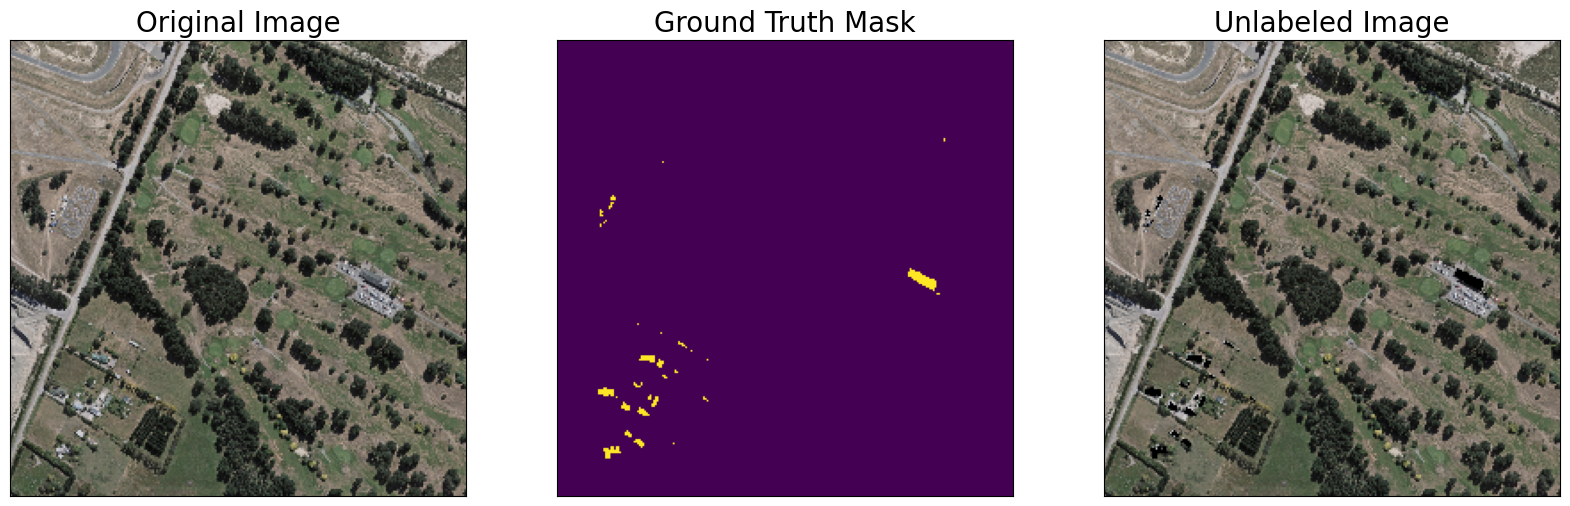

In [25]:
dataset = TheDataset(train_img_paths, train_label_paths, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask, unlabelled_image = dataset[random_idx]

ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)

visualize(
    original_image = image,
    ground_truth_mask = reverse_one_hot(mask),
    unlabeled_image = unlabelled_image
)

## Semi-Supervised Learning
#### student_model is based on the pretrained model BACKBONE.
#### teacher_model is initialized as same student model.

In [26]:
# The Student Model
student_model = sm.Linknet(backbone_name=BACKBONE, input_shape=INPUT_SHAPE, classes=NUM_CLASSES, activation='sigmoid')

# The Teacher Model (Clone of Student)
teacher_model = tf.keras.models.clone_model(student_model)
teacher_model.set_weights(student_model.get_weights())
teacher_model.trainable = False  # Teacher model is not trainable

# def semi_supervised_loss(y_true, y_pred, mask_labeled):
#     # Binary Cross-Entropy for labeled data
#     supervised_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#     supervised_loss = tf.reduce_mean(supervised_loss * mask_labeled)

#     return supervised_loss

def semi_supervised_loss(y_true, y_pred, mask_labeled, alpha=0.25, gamma=2.0):
    """
    Semi-supervised loss combining Binary Cross-Entropy (BCE) and Weighted Focal Loss.

    Arguments:
    y_true -- Ground truth tensor with last dimension containing [MASK_labeled, GT]
    y_pred -- Predicted segmentation map
    mask_labeled -- Mask indicating labeled data
    alpha -- Focal loss balancing parameter
    gamma -- Focusing parameter for hard examples

    Returns:
    Combined loss (BCE + Weighted Focal Loss)
    """

    # Binary Cross-Entropy for labeled data
    supervised_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    supervised_loss = tf.reduce_mean(supervised_loss * mask_labeled)

    # Extract MASK_labeled and Ground Truth
    MASK_labeled, GT = y_true[..., :1], y_true[..., 1:]
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)

    # Calculate Cross-Entropy Loss
    ce_loss = -GT * tf.math.log(y_pred) - (1 - GT) * tf.math.log(1 - y_pred)

    # Calculate Focal Loss
    focal_loss = alpha * tf.pow(1 - y_pred, gamma) * ce_loss

    # Corrected Weighted Focal Loss
    pfCE = tf.reduce_sum(focal_loss * MASK_labeled) / (tf.reduce_sum(MASK_labeled) + tf.keras.backend.epsilon())

    # Combine Losses
    total_loss = supervised_loss + pfCE

    return total_loss

def consistency_loss(student_output, teacher_output):
    # MSE for consistency regularization
    return tf.reduce_mean(tf.square(student_output - teacher_output))

# Pseudo-label generation using teacher model
def generate_pseudo_labels(teacher_model, images):
    return teacher_model.predict(images)


# EXPERIMENTS
#### Uncomment the configuration to run particular experiment.

In [40]:
# #Experiment A
# EPOCHS = 25
# ALPHA = 0.25
# GAMMA = 2.0
# ALPHA_TEACHER = 0.99
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# #Experiment B
# EPOCHS = 25
# ALPHA = 0.1
# GAMMA = 2
# ALPHA_TEACHER = 0.99
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# #Experiment C
# EPOCHS = 25
# ALPHA = 0.25
# GAMMA = 8
# ALPHA_TEACHER = 0.99
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# #Experiment D
# EPOCHS = 25
# ALPHA = 0.1
# GAMMA = 8
# ALPHA_TEACHER = 0.99
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

#Experiment E
EPOCHS = 25
ALPHA = 0.5
GAMMA = 0.5
ALPHA_TEACHER = 0.99
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Train Step and Update Teacher Weights Functions

In [41]:
@tf.function
def train_step(labeled_images, labeled_masks, unlabeled_images, a, y):
    with tf.GradientTape() as tape:
        # Forward pass for labeled data
        student_output_labeled = student_model(labeled_images, training=True)

        # Adjust mask for binary segmentation
        labeled_masks = tf.cast(tf.reduce_sum(labeled_masks, axis=-1, keepdims=True) > 0, tf.float32)

        # Supervised Loss
        sup_loss = semi_supervised_loss(labeled_masks, student_output_labeled, labeled_masks, alpha=a, gamma=y)

        # Forward pass for unlabeled data
        student_output_unlabeled = student_model(unlabeled_images, training=True)
        teacher_output_unlabeled = teacher_model(unlabeled_images, training=False)

        # Consistency Loss
        cons_loss = consistency_loss(student_output_unlabeled, teacher_output_unlabeled)

        # Total Loss (weighted sum)
        total_loss = sup_loss + 0.1 * cons_loss  # Adjust weight as necessary

    # Backpropagation and Optimization
    gradients = tape.gradient(total_loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

    return total_loss, sup_loss, cons_loss

def update_teacher(student_model, teacher_model, alpha=0.99):
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    new_teacher_weights = []
    for tw, sw in zip(teacher_weights, student_weights):
        new_teacher_weights.append(alpha * tw + (1 - alpha) * sw)

    teacher_model.set_weights(new_teacher_weights)

# Modeling Training

In [42]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    total_loss_avg = tf.keras.metrics.Mean()
    sup_loss_avg = tf.keras.metrics.Mean()
    cons_loss_avg = tf.keras.metrics.Mean()

    labeled_dataset = [(np.expand_dims(image, axis=0), np.expand_dims(mask, axis=0))]
    unlabeled_dataset = [np.expand_dims(unlabelled_image, axis=0)]

    for (labeled_images, labeled_masks), unlabeled_images in zip(labeled_dataset, unlabeled_dataset):
        total_loss, sup_loss, cons_loss = train_step(labeled_images, labeled_masks, unlabeled_images, ALPHA, GAMMA)

        total_loss_avg.update_state(total_loss)
        sup_loss_avg.update_state(sup_loss)
        cons_loss_avg.update_state(cons_loss)

    update_teacher(student_model, teacher_model, alpha=ALPHA_TEACHER)

    print(f"Total Loss: {total_loss_avg.result():.4f}, "
          f"Supervised Loss: {sup_loss_avg.result():.4f}, "
          f"Consistency Loss: {cons_loss_avg.result():.4f}")


Epoch 1/25
Total Loss: 0.0032, Supervised Loss: 0.0025, Consistency Loss: 0.0071
Epoch 2/25
Total Loss: 0.0029, Supervised Loss: 0.0023, Consistency Loss: 0.0065
Epoch 3/25
Total Loss: 0.0027, Supervised Loss: 0.0021, Consistency Loss: 0.0061
Epoch 4/25
Total Loss: 0.0025, Supervised Loss: 0.0019, Consistency Loss: 0.0059
Epoch 5/25
Total Loss: 0.0022, Supervised Loss: 0.0017, Consistency Loss: 0.0056
Epoch 6/25
Total Loss: 0.0021, Supervised Loss: 0.0015, Consistency Loss: 0.0053
Epoch 7/25
Total Loss: 0.0019, Supervised Loss: 0.0014, Consistency Loss: 0.0050
Epoch 8/25
Total Loss: 0.0017, Supervised Loss: 0.0012, Consistency Loss: 0.0046
Epoch 9/25
Total Loss: 0.0015, Supervised Loss: 0.0011, Consistency Loss: 0.0042
Epoch 10/25
Total Loss: 0.0014, Supervised Loss: 0.0010, Consistency Loss: 0.0039
Epoch 11/25
Total Loss: 0.0013, Supervised Loss: 0.0009, Consistency Loss: 0.0036
Epoch 12/25
Total Loss: 0.0012, Supervised Loss: 0.0009, Consistency Loss: 0.0034
Epoch 13/25
Total Loss: 0